In [216]:
# try
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.neighbors import NearestNeighbors # type: ignore

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [217]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [218]:
nodes_list = [
'Rating',
'product_category_name_encoded',
'freight_value',
'distance_km',
'month',
'is_delivery_late'
]

df[nodes_list].isnull().sum()

Rating                           0
product_category_name_encoded    0
freight_value                    0
distance_km                      0
month                            0
is_delivery_late                 0
dtype: int64

# Potential Outcomes: Effect of Delayed Delieveries on Ratings

In [219]:
# Define covariates, treatment, and outcome
covariates = ['product_category_name_encoded', 'month', 'product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'Rating'

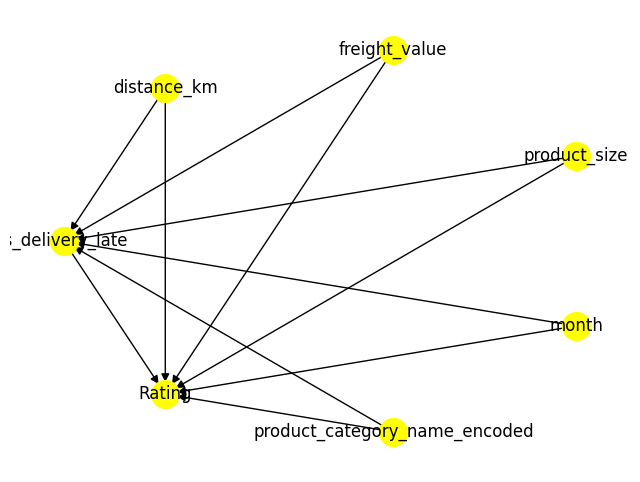

In [220]:
# Step 1: Build the causal model
# We specify the treatment, outcome, and confounders in the model.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# Step 2: View the graphical model (optional)
# This visualizes the causal structure and how variables are related.
model.view_model()

In [221]:
# Step 3: Identify the causal effect
# Specify how to estimate the causal effect. Here we use matching with propensity scores.
identified_estimand = model.identify_effect()

In [222]:
# Step 4: Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

propensity_score_matching


In [223]:
# Save the estimated effect
with open('../results/models/estimated_effect_po.pkl', 'wb') as f:
    pickle.dump(estimate, f)

In [224]:
with open('../results/models/estimated_effect_po.pkl', 'rb') as f:
    loaded_estimate = pickle.load(f)

In [225]:
loaded_estimate.interpret()

Increasing the treatment variable(s) [is_delivery_late] from 0 to 1 causes an increase of -1.9084386238364348 in the expected value of the outcome [Rating], over the data distribution/population represented by the dataset.


Let's check the distributions of treatment and control before and after matching to make sure that our PSM was successful.

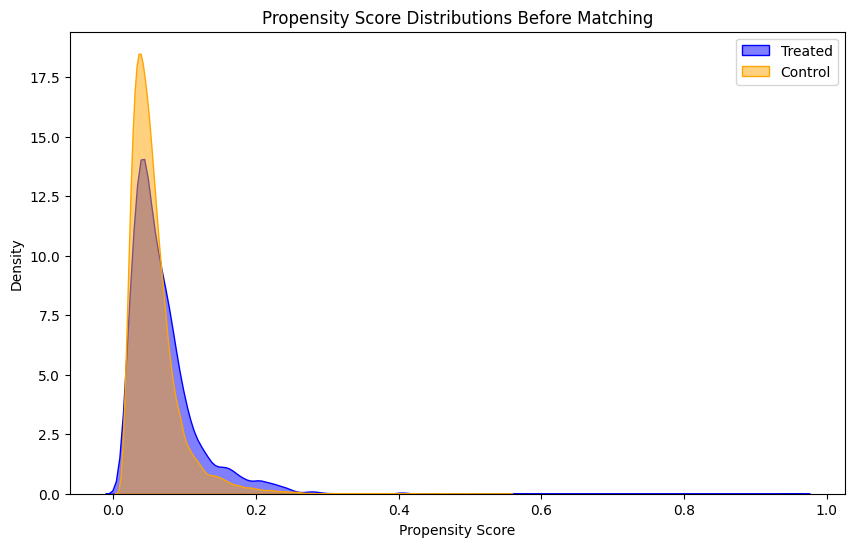

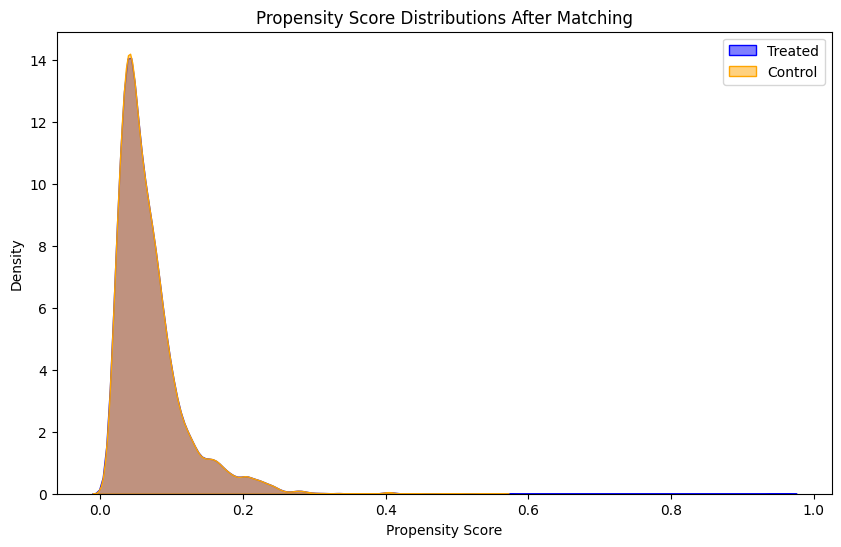

In [226]:
# Step 1: Define covariates, treatment, and outcome
covariates = ['product_category_name_encoded', 'month', 'product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'Rating'

# Step 2: Calculate Propensity Scores
# Fit a logistic regression model to estimate propensity scores
logistic = LogisticRegression()
logistic.fit(df[covariates], df[treatment])
df['propensity_score'] = logistic.predict_proba(df[covariates])[:, 1]

# Step 3: Perform Nearest Neighbor Matching
# Separate treated and control groups
treated = df[df[treatment] == 1]
control = df[df[treatment] == 0]

# Fit nearest neighbors model on control propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors for treated units
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)

# Combine treated and matched control groups
matched_data = pd.concat([treated.reset_index(drop=True), matched_control])

# Step 4: Plot Propensity Score Distributions Before and After Matching
def plot_ps_distributions(treated, control, title):
    """
    Function to plot the propensity score distributions for treated and control groups.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(treated['propensity_score'], label="Treated", color="blue", fill=True, alpha=0.5)
    sns.kdeplot(control['propensity_score'], label="Control", color="orange", fill=True, alpha=0.5)
    plt.title(title)
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Before Matching
plot_ps_distributions(treated, control, "Propensity Score Distributions Before Matching")

# After Matching
plot_ps_distributions(matched_data[matched_data[treatment] == 1], 
                      matched_data[matched_data[treatment] == 0], 
                      "Propensity Score Distributions After Matching")

Our Propensity scores distributions are much more similar now. Let's proceed.

ATE (Average Treatment Effect)

In [227]:
# Step 5: View the results
# This will show the average treatment effect (ATE) of late deliveries on review scores.
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[Rating|freight_value,distance_km,product_size,month,prod ↪
d[is_delivery_late]                                                            ↪

↪                            
↪ uct_category_name_encoded])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,freight_value,distance_km,product_size,month,product_category_name_encoded,U) = P(Rating|is_delivery_late,freight_value,distance_km,product_size,month,product_category_name_encoded)

## Realized estimand
b: Rating~is_delivery_late+freight_value+distance_km+product_size+month+product_category_name_encoded
Target units: ate

## Estimate
Mean value: -1.9084386238364348



ATT (Average Treatment Effect on Treated)

In [230]:
# Estimate ATT using DoWhy
estimate_ATT = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Specify that we are interested in the ATT (treated units)
)

# Display the ATT
print("ATT (Average Treatment effect on the Treated):", estimate_ATT.value)


propensity_score_matching
ATT (Average Treatment effect on the Treated): -1.983441910966341


ATC (Average Treatment Effect on Control)

In [231]:
# Estimate ATC using DoWhy
estimate_ATC = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc"  # Specify that we are interested in the ATC (control units)
)

# Display the ATC
print("ATC (Average Treatment effect on the Controls):", estimate_ATC.value)

propensity_score_matching
ATC (Average Treatment effect on the Controls): -1.9032966419472799


Boostrap Confidence Interval

In [228]:
# Estimate the treatment effect using Propensity Score Matching (PSM)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

# Display the causal estimate, confidence intervals, and standard error
print("Causal Estimate (ATE):", estimate.value)
print("Confidence Interval:", estimate.get_confidence_intervals())
print("Standard Error:", estimate.get_standard_error())

propensity_score_matching
Causal Estimate (ATE): -1.9084386238364348
Confidence Interval: (np.float64(-1.9709598488344757), np.float64(-1.8569413362823384))
Standard Error: 0.0339360290972428


Sensitivity Analysis: Unobserved Confounder

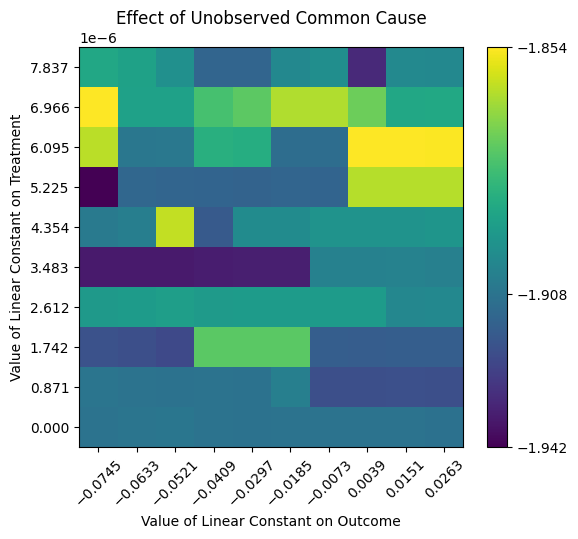

Refute: Add an Unobserved Common Cause
Estimated effect:-1.9084386238364348
New effect:(np.float64(-1.942276930582768), np.float64(-1.8537777509262494))



In [229]:
# Add an unobserved confounder and see how the treatment effect changes
refutation_unobserved_confounding = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)

# Display the refutation results
print(refutation_unobserved_confounding)

-----